# WEEK 1

**Week 1**

*Installing Google Earth Engine API*

In [11]:
# Install required libraries
!pip install earthengine-api geemap --quiet


*Importing libraries*

In [12]:
# Import packages
import ee
import geemap
import pandas as pd
import os


Connecting it to Google Drive

In [3]:
df=pd.read_csv('glofdatabase_v4-1.csv')
pd.set_option('display.max_columns',None)
df.shape

(684, 77)

In [4]:
df.head(5)

,ID,Major_RGI_Region,Mountain_range_Region,Country,Glacier,RGI_Glacier_Id,RGI_Glacier_Area,Lake,Lake_type,Longitude,Latitude,River,Date,Date_Min,Date_Max,Mechanism,Mean_Lake_Volume_VL,Min_VL,Max_VL,VL_calculation,Mean_Flood_Volume_V0,Min_V0,Max_V0,V0_calculation,Peak_discharge_Qp,Min_Qp,Max_Qp,Qp_calculation,Impact_and_destruction,reported_impacts,economic_losses,D_buildings,D_bridges,D_roads_paths,D_railroads,D_utilities,D_flood_protection,D_environmental,resettlement,reported_fatalities,Further_comments,First_reference_found,Reference,Reference_comments,Lake_area_before,Perimeter_before,Image_date_before,Satellite_before,Scenename_before,Certainty_level_before,Lake_area_after,Perimeter_after,Image_date_after,Satellite_after,Scenename_after,Certainty_level_after,Lake_area_comments,Unnamed: 57,Unnamed: 58,Unnamed: 59,Unnamed: 60,Unnamed: 61,Unnamed: 62,Unnamed: 63,Unnamed: 64,Unnamed: 65,Unnamed: 66,Unnamed: 67,Unnamed: 68,Unnamed: 69,Unnamed: 70,Unnamed: 71,Unnamed: 72,Unnamed: 73,Unnamed: 74,Unnamed: 75,Unnamed: 76
0,running number (regionally),RGI region in which the GLOF occurred,Major mountain unit/range in which the GLOF wa...,Source location of the GLOF,Name of the glacier that feeds the burst glaci...,Glacier Id derived from RGI polygon,Glacier area derived from RGI polygon,Name of the outburst source lake,Material of the impounding dam,X coordinate,Y coordinate,Major river basin that captured GLOF discharge,Reported date of GLOF,Earliest possible date,Latest possible date,Mechanism that causes the dam to fail,Volume before outburst,Minimum reported lake volume,Maximum reported lake volume,Method to obtain lake volumes before outburst,Total volume released during outburst,Minimum reported flood volume,Maximum reported flood volume,Method to obtain V0,Maximum discharge during outburst,Minimum reported peak discharge,Maximum reported peak discharge,Method to obtain Qp,Quantitative and qualitative descriptions of s...,Reported impacts (categorized),Occurrence of economic losses,Damage to buildings,Damage to bridges,Damage to roads or paths,Damage to railroads,Damage to utilities,Damage to flood protection measures,Damage to the environment,Need for resettlement after the flood,Fatalities in consequence of the flood,Any other useful information,Year of first reference that cited the GLOF,References viewed to gather information,Comments on the reference,Lake area before outburst,Lake perimeter before outburst,Date of satellite image used for mapping,Satellite from which the image was derived,Scenename,"1 – unsure (clouds, shadows,…)",lake area after outburst,Lake perimeter before outburst,Date of satellite image used for mapping,Satellite from which the image was derived,Scenename,"1 – unsure (clouds, shadows,...)",Mapping notes and comments,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,e.g. Karakoram,e.g. Pakistan,e.g. Baltoro Glacier,NaN,km2,e.g. Baltoro Lake 1,"e.g ice, moraine, water pocket, bedrock, combined",XX.XX°,XX.XX°,e.g. Indus,YYYY-MM-DD,YYYY-MM-DD,YYYY-MM-DD,"(e.g. overtopping, breach, tunnelling, englac...",106 m³,106 m³,106 m³,e.g. bathymetry,106 m³,106 m³,106 m³,gaged / estmated / unknown,m³ s-1,m³ s-1,m³ s-1,gaged / estmated / unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(e.g. water or electricity supply),(e.g. levees),(e.g. fish population),NaN,NaN,NaN,NaN,NaN,NaN,m²,m,YYYY-MM_DD,NaN,NaN,2 – sure,m²,m,YYYY-MM_DD,NaN,NaN,2 – sure,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,Low Latitudes,Low-latitude Andes,Peru,RGI60-16.02480,RGI60-16.02480,4.52,Rajururi,moraine,-77.68,-9.06,NaN,1725-01-06,NaN,NaN,breach,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,earthquake triggered,1942,"Broggi, J. A. (1942). Informe preliminar sobre...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2,Southern Andes,C A


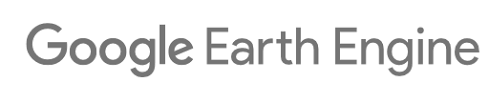
[Google Earth Engine Code](https://code.earthengine.google.com/)


**GEE Authentication & Initialization**

In [16]:
ee.Authenticate()
ee.Initialize(project='fleet-hawk-463015-h5')

## Lake Detection & Visualization

In [6]:
# Create interactive map
Map = geemap.Map(basemap='SATELLITE',center=[27.71, 85.32],zoom=7)
Map.add_draw_control()


# Load all countries from Earth Engine
world_borders = ee.FeatureCollection("FAO/GAUL/2015/level1")

styled_world = world_borders.style(**{
    'color': 'red',
    'width': 2,
    'fillColor': '00000000'  # Transparent fill
})
Map.addLayer(styled_world, {}, 'FAO Country Borders')

Map


Map(center=[27.71, 85.32], controls=(WidgetControl(options=['position', 'transparent_bg'], position='topright'…

Returns Geometry(ROI) that user drew on the map.

Returns Geometry(ROI) that user drew on the map.

In [7]:
roi = Map.user_roi
if roi is None:
  print("No ROI selected, Please select roi using the interactive map")
else:
  print("ROI loaded")
  print(type(roi))

#Map.user_roi is a variable that holds an object of class ee.Geometry. it is assigned the geometry object when the user draws on the map


No ROI selected, Please select roi using the interactive map


In [8]:
def detect_lakes_by_ndwi(year, polygon, ndwi_thresh=0.3, cloud_thresh=60):
    s2 = ee.ImageCollection("COPERNICUS/S2_SR") \
        .filterDate(f'{year}-06-15', f'{year}-10-15') \
        .filterBounds(polygon) \
        .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", cloud_thresh))

    def compute_ndwi(img):
        return img.normalizedDifference(['B3', 'B8']).rename('NDWI') \
            .copyProperties(img, img.propertyNames())

    ndwi_collection = s2.map(compute_ndwi)
    ndwi_median = ndwi_collection.median().clip(polygon)

    water_mask = ndwi_median.gt(ndwi_thresh).focal_max(1).focal_min(1)

    lake_polygons = water_mask.selfMask().reduceToVectors(
        geometry=polygon,
        scale=10,
        geometryType='polygon',
        reducer=ee.Reducer.countEvery(),
        maxPixels=1e13
    )

    # Filter small lakes < 0.15 km²
    lake_polygons = lake_polygons.map(lambda f: f.set('area', f.geometry().area(20)))
    filtered_lakes = lake_polygons.filter(ee.Filter.gt('area', 150000))

    return ndwi_median, filtered_lakes

In [12]:
def count_lakes(lakes_fc):
    count = lakes_fc.size()
    n = count.getInfo()
    print(f" Number of lakes detected: {n}")
    return n

Lake detection(forming ee.FeatureCollection with lake polygons by taking lake coordinate and time frame, 

In [33]:
import ee


def detect_lake_from_point(point, start_date, end_date,
                        search_radius=800, ndwi_thresh=0.30):

    aoi = point.buffer(search_radius)

    # Load Landsat 8/9 SR
    collection = (ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
                  .filterDate(start_date, end_date)
                  .filterBounds(aoi))

    # Scale factors for SR
    def scale_sr(img):
        optical = img.select('SR_B[0-9]*').multiply(0.0000275).add(-0.2)
        thermal = img.select('ST_B.*').multiply(0.00341802).add(149.0)
        return img.addBands(optical, overwrite=True).addBands(thermal, overwrite=True)

    collection = collection.map(scale_sr)

    # Add NDWI band
    def add_ndwi(img):
        ndwi = img.normalizedDifference(['SR_B3', 'SR_B5']).rename('NDWI')
        return img.addBands(ndwi)
    collection = collection.map(add_ndwi)

    # Check empty collection
    if collection.size().getInfo() == 0:
        raise Exception("No usable Landsat images found")

    # Median NDWI
    ndwi_median = collection.select('NDWI').median().clip(aoi)

    # Safeguard: check band names
    if len(ndwi_median.bandNames().getInfo()) == 0:
        raise Exception("NDWI band missing after processing")

    # Water mask
    water_mask = ndwi_median.gt(ndwi_thresh)

    # Vectorize
    lake_fc_all = water_mask.selfMask().reduceToVectors(
        geometry=aoi,
        scale=30,
        geometryType='polygon',
        reducer=ee.Reducer.countEvery(),
        maxPixels=1e13
    )

    def add_area(f): return f.set('area_km2', f.geometry().area(maxError=1).divide(1e6))
    lake_fc_all = lake_fc_all.map(add_area)

    largest = ee.Feature(lake_fc_all.sort('area_km2', False).first())

    return {
        'lake_fc': ee.FeatureCollection([largest]),
        'area_km2': largest.get('area_km2'),
        'ndwi_median': ndwi_median
    }




In [34]:
lat, lon = 36.879,73.704

point = ee.Geometry.Point([lon, lat])

# Call Landsat-only function
res = detect_lake_from_point(
    point,
    start_date="2016-09-01",
    end_date="2016-12-30"
)

# Print lake area
print("Lake area (km²):", res['area_km2'].getInfo())

Lake area (km²): 0.0021547874021803828


In [24]:
'''labels.reduceRegion(...) → Summarizes the values of labels within a specific geometry (here: point).

reducer=ee.Reducer.first() → Returns the first non-null pixel value in that geometry.

Since the geometry is a single point, "first" just means "that pixel value".

geometry=point → The exact point you passed to the function.

scale=10 → Pixel size in meters; matches Sentinel-2 resolution.

.get('labels') → Extracts the numeric label ID from the dictionary returned by reduceRegion.

If the point is on water: returns a positive integer (e.g., 3).

If the point is not on water: returns None (null).'''

'labels.reduceRegion(...) → Summarizes the values of labels within a specific geometry (here: point).\n\nreducer=ee.Reducer.first() → Returns the first non-null pixel value in that geometry.\n\nSince the geometry is a single point, "first" just means "that pixel value".\n\ngeometry=point → The exact point you passed to the function.\n\nscale=10 → Pixel size in meters; matches Sentinel-2 resolution.\n\n.get(\'labels\') → Extracts the numeric label ID from the dictionary returned by reduceRegion.\n\nIf the point is on water: returns a positive integer (e.g., 3).\n\nIf the point is not on water: returns None (null).'

In [31]:
lake_point = ee.Geometry.Point([73.704, 36.879])

ndwi_img, lake_poly = detect_lake_from_point(
    point=lake_point,
    start_date='2022-06-01',
    end_date='2022-09-30',
    search_radius=2000,  # try bigger radius
    ndwi_thresh=0.2      # try looser threshold
)

Map = visualize_ndwi_and_lakes(
    ndwi_image=ndwi_img,
    lakes_fc=lake_poly,
    polygon=lake_point.buffer(2000),
    year=2022
)
Map



AttributeError: 'str' object has no attribute 'style'

In [11]:
ndwi_2024, lakes_2024= detect_lakes_by_ndwi(2024,roi)


In [12]:
count_lakes(lakes_2024)

 Number of lakes detected: 5


5

In [21]:
import geemap

def visualize_ndwi_and_lakes(ndwi_image, lakes_fc, polygon, year=2024):
    """
    Visualizes NDWI image and detected lakes on an interactive map.
    """
    Map = geemap.Map(basemap='SATELLITE',center=[36.879, 73.704], zoom=10)
    Map.addLayer(ndwi_image, {'min': 0, 'max': 1, 'palette': ['white', 'blue']}, f'NDWI {year}')
    Map.addLayer(lakes_fc.style(**{'color': 'cyan', 'fillColor': '0000ff80'}), {}, f'Lakes {year}')
    Map.addLayer(polygon, {'color': 'red'}, 'ROI')

    return Map

In [14]:
visualize_ndwi_and_lakes(ndwi_2024, lakes_2024, roi)

Map(center=[27.75, 86.85], controls=(WidgetControl(options=['position', 'transparent_bg'], position='topright'…

# WEEK 2

**WEEK 2**

In [20]:

# Add centroid coordinates to each feature
def add_centroid_coords(feature):

    # Get the centroid of the feature's geometry (lake polygon)
    #   - ee.ErrorMargin(1) specifies a 1-meter error tolerance in calculation.
    #   - The result is an ee.Geometry.Point object.
    centroid = feature.geometry().centroid(ee.ErrorMargin(1))

    # Add two new properties to the feature:
    #   'centroid_lat' → the latitude of the centroid (index 1 in [lon, lat])
    #   'centroid_lon' → the longitude of the centroid (index 0 in [lon, lat])
    #   centroid.coordinates() returns an ee.List: [longitude, latitude]
    return feature.set({
        'centroid_lat': centroid.coordinates().get(1),  # latitude
        'centroid_lon': centroid.coordinates().get(0)   # longitude
    })


In [21]:

# Add a unique lake ID to each feature
def add_lake_id(feature):
    """
    Creates a reproducible unique lake_id from centroid coordinates.
    This helps track the same lake across years or datasets.
    """

    # Get centroid latitude from feature properties, ensure it's an ee.Number,
    # and format it to a string with exactly 6 decimal places for consistency.
    lat = ee.Number(feature.get('centroid_lat')).format('%.6f')

    # Do the same for centroid longitude
    lon = ee.Number(feature.get('centroid_lon')).format('%.6f')

    # Build the lake_id string in the format: lake_<lat>_<lon>
    #   - ee.String('lake_') → start with the prefix
    #   - .cat(lat) → append latitude string
    #   - .cat('_') → add an underscore separator
    #   - .cat(lon) → append longitude string
    lake_id_str = ee.String('lake_').cat(lat).cat('_').cat(lon)

    # Add the new 'lake_id' property to the feature's property dictionary
    # and return the updated feature
    return feature.set('lake_id', lake_id_str)

In [22]:
# Add area for a given year
def add_lake_area(feature, year, scale=30):
    """Calculates lake area (km²) and stores it as a property."""

    # Create an image where each pixel value = pixel area in km²
    pixel_area_km2 = ee.Image.pixelArea().divide(1e6).rename('area')

    # Sum pixel areas inside the lake polygon
    area = pixel_area_km2.reduceRegion(
        reducer=ee.Reducer.sum(),        # sum all pixel values
        geometry=feature.geometry(),     # use lake's polygon
        scale=scale,                     # resolution in meters
        maxPixels=1e13                    # allow large calculations
    ).get('area')

    # Add computed area to feature properties
    return feature.set(f'area_km2_{year}', area)

In [23]:
#Enrich lakes with available properties
#1
def enrich_lakes(lakes_fc, year, scale=30):
    """Adds centroid, lake ID, and area to each feature."""
    lakes_fc = lakes_fc.map(add_centroid_coords)
    lakes_fc = lakes_fc.map(add_lake_id)
    lakes_fc = lakes_fc.map(lambda f: add_lake_area(f, year, scale))
    return lakes_fc

In [24]:
#Convert FeatureCollection to Pandas DataFrame
def lakes_to_df(lakes_fc):
    """Converts EE FeatureCollection to a Pandas DataFrame."""
    return geemap.ee_to_df(lakes_fc)

In [25]:
lakes_fc_2024 = enrich_lakes(lakes_2024, 2024, 30)
df_2024 = lakes_to_df(lakes_fc_2024)

In [26]:
df_2024.head()

,area,area_km2_2024,centroid_lat,centroid_lon,count,label,lake_id
0,378995.874569,0.378364,27.874191,86.586037,4297,1,lake_27.874191_86.586037
1,293695.492215,0.293561,27.780408,86.613991,3327,1,lake_27.780408_86.613991
2,235514.686348,0.235016,27.742659,86.844783,2667,1,lake_27.742659_86.844783
3,297215.534628,0.296743,27.687292,86.858751,3364,1,lake_27.687292_86.858751
4,525462.949261,0.524339,27.771688,86.869145,5952,1,lake_27.771688_86.869145


In [30]:
# 1. Function to add elevation to each feature
def add_lake_elevation(feature):
    dem = ee.Image("USGS/SRTMGL1_003")  # SRTM 30m DEM
    elevation = dem.reduceRegion(
        reducer=ee.Reducer.first(),
        geometry=feature.geometry().centroid(1),
        scale=30
    ).get('elevation')
    return feature.set('elevation_m', elevation)

# 2. Update enrich_lakes to include elevation
def enrich_lakes(lakes_fc, year, scale=30):
    lakes_fc = lakes_fc.map(add_centroid_coords)
    lakes_fc = lakes_fc.map(add_lake_id)
    lakes_fc = lakes_fc.map(lambda f: add_lake_area(f, year, scale))
    lakes_fc = lakes_fc.map(add_lake_elevation)
    return lakes_fc

lakes_fc_2024 = enrich_lakes(lakes_2024, 2024, 30)
df_2024 = lakes_to_df(lakes_fc_2024)

In [29]:
df_2024.head()

,area,area_km2_2024,centroid_lat,centroid_lon,count,elevation_m,label,lake_id
0,378995.874569,0.378364,27.874191,86.586037,4297,4368,1,lake_27.874191_86.586037
1,293695.492215,0.293561,27.780408,86.613991,3327,4831,1,lake_27.780408_86.613991
2,235514.686348,0.235016,27.742659,86.844783,2667,4368,1,lake_27.742659_86.844783
3,297215.534628,0.296743,27.687292,86.858751,3364,4764,1,lake_27.687292_86.858751
4,525462.949261,0.524339,27.771688,86.869145,5952,4940,1,lake_27.771688_86.869145


# WEEK 3

# WEEK 4

# WEEK 5

**Lake Expansion Rate **

In [19]:
import ee
import pandas as pd
ee.Initialize()

def get_landsat_collection(year):
    if year <= 2011:
        return 'LANDSAT/LT05/C02/T1_L2'
    elif year < 2013:
        return 'LANDSAT/LE07/C02/T1_L2'
    else:
        return 'LANDSAT/LC08/C02/T1_L2'

def get_landsat_ndwi_area(lat, lon, year, buffer_m=60):
    geom = ee.Geometry.Point(lon, lat).buffer(buffer_m)
    collection_id = get_landsat_collection(year)
    col = (ee.ImageCollection(collection_id)
           .filterDate(f"{year}-06-01", f"{year}-09-30")
           .filterBounds(geom))
    
    # Apply cloud mask & NDWI
    def add_ndwi(img):
        band_green, band_nir = ('SR_B2', 'SR_B4') if 'LT05' in collection_id or 'LE07' in collection_id else ('SR_B3', 'SR_B5')
        ndwi = img.normalizedDifference([band_green, band_nir]).rename('NDWI')
        return img.addBands(ndwi)
    
    def mask_clouds(img):
        qa = img.select('QA_PIXEL')
        cloud_mask = qa.bitwiseAnd(1 << 3).eq(0) \
                   .And(qa.bitwiseAnd(1 << 4).eq(0))
        return img.updateMask(cloud_mask)
    
    ndwi_median = (col.map(mask_clouds)
                      .map(add_ndwi)
                      .median())
    
    water_mask = ndwi_median.select('NDWI').gt(0.3)
    area_m2 = water_mask.multiply(ee.Image.pixelArea()) \
                        .reduceRegion(ee.Reducer.sum(), geom, 30) \
                        .get('NDWI')
    
    return ee.Number(area_m2).divide(1e6)  # km²

def calculate_expansion_rate(lat, lon, year_start, year_end):
    area_start = get_landsat_ndwi_area(lat, lon, year_start).getInfo()
    area_end = get_landsat_ndwi_area(lat, lon, year_end).getInfo()
    rate = (area_end - area_start) / (year_end - year_start)
    return area_start, area_end, rate

def apply_expansion_rate_to_df(df):
    results = []
    for _, row in df.iterrows():
        if pd.notna(row.get('glof_year')):
            year_end = int(row['glof_year']) - 1
            year_start = year_end - 10
        else:
            year_end = 2024
            year_start = 2014
        a_start, a_end, rate = calculate_expansion_rate(row['latitude'], row['longitude'], year_start, year_end)
        results.append({'area_start': a_start, 'area_end': a_end, 'expansion_rate': rate})
    return pd.concat([df.reset_index(drop=True), pd.DataFrame(results)], axis=1)


*Data Cleaning: getting GLOF lakes*

In [2]:
import pandas as pd


In [5]:
!pip install openpyxl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [openpyxl]


In [6]:
allsheets_df=pd.read_excel("glofdatabase_v4-1.xlsx",sheet_name=None)
pd.set_option('display.max_columns',None)

In [7]:
print(allsheets_df.keys())

dict_keys(['Andes', 'NW North America', 'European Alps', 'Scandinavia', 'High Mountain Asia', 'Other', 'Iceland', 'Greenland'])


In [ ]:
print(allsheets_df['glofdatabase_v4-1'].head())

In [ ]:
df_gloflist=[]
for sheet_name,sheet_df in allsheets_df.items():
  if sheet_name=='glofdatabase_v4-1':
    continue
  sheet_df=pd.read_excel(
      'glofdatabase_v4-1.xls',
      sheet_name=sheet_name,
      header=0,
      skiprows=[1,2])  #skips metadata row
  sheet_df['Region']=sheet_name
  df_gloflist.append(sheet_df)

df_glof=pd.concat(df_gloflist,ignore_index=True)

In [ ]:
df_glof.head(5)

In [ ]:
keep_cols = [
    "Major_RGI_Region",
    "Mountain_range_Region",
    "Country",
    "RGI_Glacier_Area",
    "Lake_type",
    "Longitude",
    "Latitude",
    "Lake_area_before",
    "Date",
    "Date_Min",
    "Region"
]

df_glof = df_glof[keep_cols]

In [ ]:
df_glof.head(5)

Lake area: using 3 years including the desired year.

In [39]:

import ee

def detect_lake_from_point(point, year, search_radius=5000, ndwi_thresh=0.25):
    """
    Detect glacial lake polygon & area from a point using Landsat C2 L2 SR.
    Uses Sep–Dec median NDWI over year-1, year, year+1.
    Includes cloud/snow/shadow masking + scaling.
    """

    aoi = point.buffer(search_radius)

    # --- Cloud / snow / shadow mask ---
    def mask_landsat_clouds(img):
        qa = img.select('QA_PIXEL')
        cloud        = 1 << 3
        cloud_shadow = 1 << 4
        snow         = 1 << 5
        mask = (qa.bitwiseAnd(cloud).eq(0)
                  .And(qa.bitwiseAnd(cloud_shadow).eq(0))
                  .And(qa.bitwiseAnd(snow).eq(0)))
        return img.updateMask(mask)

    # --- Scale surface reflectance ---
    def scale_sr(img):
        optical = img.select('SR_B[0-9]*').multiply(0.0000275).add(-0.2)
        return img.addBands(optical, overwrite=True)

    # --- Add NDWI ---
    def add_ndwi(img):
        ndwi = img.normalizedDifference(['SR_B3','SR_B5']).rename('NDWI')
        return img.addBands(ndwi)

    # --- Build fall collection for a year ---
    def get_fall_collection(y):
        return (ee.ImageCollection("LANDSAT/LC08/C02/T1_L2")
                .filterDate(f"{y}-09-01", f"{y}-12-31")
                .filterBounds(aoi)
                .map(mask_landsat_clouds)
                .map(scale_sr)
                .map(add_ndwi))

    # Merge year-1, year, year+1
    collection = (get_fall_collection(year-1)
                  .merge(get_fall_collection(year))
                  .merge(get_fall_collection(year+1)))

    if collection.size().getInfo() == 0:
        raise Exception("No usable Landsat images found")

    # Median NDWI
    ndwi_median = collection.select('NDWI').max().clip(aoi)

    if len(ndwi_median.bandNames().getInfo()) == 0:
        raise Exception("NDWI band missing after processing")

    # Water mask
    water_mask = ndwi_median.gt(ndwi_thresh)

    # Vectorize
    lake_fc_all = water_mask.selfMask().reduceToVectors(
        geometry=aoi,
        scale=30,
        geometryType='polygon',
        reducer=ee.Reducer.countEvery(),
        maxPixels=1e13
    )

    # Add area (ha)
    def add_area(f):
        return f.set('area_ha', f.geometry().area(maxError=1).divide(1e4))
    lake_fc_all = lake_fc_all.map(add_area)

    # Largest polygon
    largest = ee.Feature(lake_fc_all.sort('area_ha', False).first())

    return {
        'lake_fc': ee.FeatureCollection(ee.Algorithms.If(largest, [largest], [])),
        'area_ha': ee.Algorithms.If(largest, largest.get('area_ha'), None),
        'ndwi_median': ndwi_median
    }

In [40]:
lat, lon = 27.989,97.369
lake_point = ee.Geometry.Point(lon, lat)

res = detect_lake_from_point(lake_point, year=2016)
print("Lake area (ha):", res['area_ha'].getInfo())

Lake area (ha): 43.215971588507


*Glacier Features: mapping glacier to lake point*

In [37]:

lake = ee.Geometry.Point(lon, lat)

# 2. Load GLIMS glacier dataset
glaciers = ee.FeatureCollection("GLIMS/current")

# 3. Filter glaciers within 50 km
region = lake.buffer(50000)
nearby_glaciers = glaciers.filterBounds(region)

# 4. Add distance to each glacier
glaciers_with_dist = nearby_glaciers.map(
    lambda g: g.set("distance_m", g.geometry().distance(lake))
)

# 5. Nearest glacier
nearest_glacier = glaciers_with_dist.sort("distance_m").first()

# 6. Extract geometry for visualization
nearest_glacier_geom = ee.Feature(nearest_glacier).geometry()

# 7. Centroids for line
lake_centroid = lake.centroid()
glacier_centroid = nearest_glacier_geom.centroid()
line = ee.Geometry.LineString([lake_centroid.coordinates(), glacier_centroid.coordinates()])

# 8. Map visualization
m = geemap.Map(center=[lat, lon], zoom=10)
m.add_basemap("SATELLITE")

m.addLayer(lake, {"color": "blue"}, "Lake Point")
m.addLayer(nearest_glacier_geom, {"color": "red"}, "Nearest Glacier Polygon")  # use geometry
m.addLayer(line, {"color": "green"}, "Connection Line")

m


Map(center=[27.926, 87.771], controls=(WidgetControl(options=['position', 'transparent_bg'], position='toprigh…

*glacier features: mapping glacier to lake point with lake polygon*

In [38]:
import ee, geemap


lake_point = ee.Geometry.Point(lon, lat)

# Detect lake polygon
lake_result = detect_lake_from_point(
    lake_point, start_date="2016-06-01", end_date="2016-12-31"
)
lake_fc = lake_result['lake_fc']

# Nearest glacier
glaciers = ee.FeatureCollection("GLIMS/current")
nearby = glaciers.filterBounds(lake_point.buffer(50000))
with_dist = nearby.map(lambda g: g.set("distance_m", g.geometry().distance(lake_point)))
nearest = with_dist.sort("distance_m").first()
nearest_geom = ee.Feature(nearest).geometry()

# Connection line
line = ee.Geometry.LineString([lake_point.coordinates(), nearest_geom.centroid().coordinates()])

# -------------------------
# DEM overlay (SRTM 30m)
dem = ee.Image("USGS/SRTMGL1_003")

# Visualization parameters
dem_vis = {
    'min': 4000,   # adjust for Himalayas
    'max': 8000,
    'palette': ['blue', 'green', 'yellow', 'orange', 'red', 'white']
}

# -------------------------
# Map
m = geemap.Map(center=[lat, lon], zoom=11)
m.add_basemap("SATELLITE")

# Add DEM as background layer
m.addLayer(dem, dem_vis, "DEM Elevation")

# Add features
m.addLayer(lake_point, {"color": "blue"}, "Lake Point")
m.addLayer(lake_fc, {"color": "cyan"}, "Lake Polygon (NDWI)")
m.addLayer(nearest_geom, {"color": "black"}, "Nearest Glacier")
m.addLayer(line, {"color": "green"}, "Connection Line")

m


TypeError: detect_lake_from_point() got an unexpected keyword argument 'start_date'

# WEEK 6